In [5]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shapefile
import pandas as pd
import seaborn as sns
from scipy import stats 
import scipy
from scipy.special import factorial
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import math
from cleanData import getCleanTripData, getCleanFareData, getTripData
from identifySuburbs import TaxiZone, Point, process_zones, haversine_distance, manhattan_distance


In [6]:
fare = getTripData('./data/loc_hash_3_trip_4_2013.csv')
fare = getCleanTripData(fare)

In [7]:
# Cleaning data
fare_amount_filter = ((fare.fare_amount >= 2.0) & (fare.fare_amount <= 200.0))
payment_type_filter = ((fare.payment_type == 'CRD') | (fare.payment_type == 'CSH'))
fare = fare[fare_amount_filter & payment_type_filter]

In [8]:
#Feature engineering
fare['pickup_datetime'] = pd.to_datetime(fare.pickup_datetime) 
fare['pickup_day'] = fare['pickup_datetime'].dt.day
fare['pickup_hour'] = fare['pickup_datetime'].dt.hour
fare['pickup_weekday'] = fare['pickup_datetime'].dt.weekday
fare['pickup_weekhour'] = fare['pickup_datetime'].dt.weekday*24 + fare['pickup_hour']
fare['tip_percent'] = 100*fare['tip_amount'] / fare['total_amount']
fare.head(5)

,Unnamed: 0,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,...,tolls_amount,total_amount,id.1,pick_locid,drop_locid,pickup_day,pickup_hour,pickup_weekday,pickup_weekhour,tip_percent
0,4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,N,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,...,0.0,19.20,205A696DF62AD03C88DA8C5EC5248639579C41EA5EC846...,246,141,4,20,3,92,16.666667
1,38,9827CDDA5D85B9C70A29ACE3824B644C,2BF23762F9D01A0723FE1B35996597C3,CMT,1,N,2013-04-04 14:39:58,2013-04-04 14:49:11,1,552,...,0.0,11.40,9827CDDA5D85B9C70A29ACE3824B644C2BF23762F9D01A...,239,48,4,14,3,86,16.666667
2,144,5BAA424F00F10358D10A8DCBBEDFDC27,91953611F278BD5D2B44C0FF82F45E1C,CMT,1,N,2013-04-04 07:37:50,2013-04-04 08:03:18,1,1528,...,0.0,31.00,5BAA424F00F10358D10A8DCBBEDFDC2791953611F278BD...,237,231,4,7,3,79,6.451613
3,156,49B8CFC71F0ED39C7B3F68F603DB9D05,5735FE2E3DC1CE2FC5DDA20579E1FD18,VTS,1,NaN,2013-04-12 23:29:00,2013-04-12 23:43:00,1,840,...,0.0,19.10,49B8CFC71F0ED39C7B3F68F603DB9D055735FE2E3DC1CE...,161,7,12,23,4,119,16.230366
4,178,AFE81C8DACF7151CBB3B2F4838883A8E,AF876139D0E7D99BE4F90FD49921559F,VTS,1,NaN,2013-04-12 23:39:00,2013-04-12 23:46:00,1,420,...,0.0,9.88,AFE81C8DACF7151CBB3B2F4838883A8EAF876139D0E7D9...,68,249,12,23,4,119,19.028340


In [9]:
#,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,
#passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,
#dropoff_latitude,id,medallion.1,hack_license.1,vendor_id.1,pickup_datetime.1,payment_type,
#fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,id.1,pick_locid,drop_locid
print('Started.')
# We only given time, pickup and dropoff location
zones = process_zones('./data/taxi_zones/taxi_zones.json')
alldata = fare[['id', 'pick_locid', 'drop_locid', 'fare_amount',
                'pickup_datetime', 'pickup_day','pickup_hour',
                'pickup_weekday','pickup_longitude', 
                'passenger_count','payment_type',
                'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

JFK_locid = 132
LaGuardia_locid = 138
Newark_locid = 1
airports = [JFK_locid, LaGuardia_locid, Newark_locid]

manhatten = []
for z in zones:
    if z.boro == "Manhattan":
        manhatten.append(z.locID)
manhetten_mapper_to = {}
manhetten_mapper_from = {}
airport_mapper = {}
for index, row in alldata.iterrows():
    ids = row['id']
    ploc = row['pick_locid']
    dloc = row['drop_locid']
    if ploc in manhatten:
        manhetten_mapper_from.update({ids: 1})
    else:
        manhetten_mapper_from.update({ids: 0})
    if dloc in manhatten:
        manhetten_mapper_to.update({ids: 1})
    else:
        manhetten_mapper_to.update({ids: 0})
        
    if ploc in airports or dloc in airports:
        airport_mapper.update({ids: 1})
    else:
        airport_mapper.update({ids: 0})

print("Done")

Started.
Done


In [10]:
s = time.time()
col1 = 'manhattan_to'
alldata = alldata.assign(**{col1:np.full(len(alldata.index), int(-2))})

col2 = 'manhattan_from'
alldata = alldata.assign(**{col1:np.full(len(alldata.index), int(-2))})

col3 = 'InAirports'
alldata = alldata.assign(**{col2:np.full(len(alldata.index), int(-2))})

alldata[col1] = alldata['id'].map(manhetten_mapper_to)
alldata[col2] = alldata['id'].map(manhetten_mapper_from)
alldata[col3] = alldata['id'].map(airport_mapper)
e = time.time()
print("Time: {} ".format(e-s))

Time: 1.448936939239502 


In [11]:
alldata.loc[:,'hvsine_pick_drop'] = haversine_distance(alldata['pickup_latitude'].values, alldata['pickup_longitude'].values, alldata['dropoff_latitude'].values, alldata['dropoff_longitude'].values)
alldata.loc[:,'manh_pick_drop'] = manhattan_distance(alldata['pickup_latitude'].values, alldata['pickup_longitude'].values, alldata['dropoff_latitude'].values, alldata['dropoff_longitude'].values)
#alldata.loc[:,'is_card_payment'] = 1*(alldata['payment_type'] == 'CRD')

In [12]:
# from pandas.tools.plotting import parallel_coordinates
# parallel_coordinates(alldata.sample(1200)[['InManhattan','pickup_weekday', 'passenger_count', 'InAirports']], 'InAirports', colormap='rainbow')
# plt.show()

In [13]:
mask_p = (alldata.pick_locid == 400)
mask_d = (alldata.drop_locid == 400)
alldata.loc[mask_p, 'pick_locid'] = 0
alldata.loc[mask_d, 'drop_locid'] = 0

alldata = alldata.drop(['id', 'pickup_datetime'],axis=1)
alldata = alldata.drop('payment_type',axis=1)

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# # Prepearing test, train and cross validation sets
train_len = int(len(alldata.index) * 0.6)
test_len = int(len(alldata.index) * 0.2)
crossval_len = int(len(alldata.index) * 0.2)

train = None
train = alldata.loc[:train_len,:]
train_target = train.fare_amount
train = train.drop(['fare_amount'], axis=1)
scaler = StandardScaler().fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), index=train.index.values, columns=train.columns.values)
pca_scaled = PCA()
pca_scaled.fit(train_scaled)
train_pca = pd.DataFrame(pca_scaled.transform(train_scaled))
print(len(train.index))

test = alldata.loc[train_len:train_len+test_len,:]
test_target = test.fare_amount
test = test.drop(['fare_amount'], axis=1)
test_scaled = pd.DataFrame(scaler.transform(test), index=test.index.values, columns=test.columns.values)
test_pca = pd.DataFrame(pca_scaled.transform(test_scaled))
print(len(test.index))

cross_val = alldata.loc[train_len+test_len:,:]
cross_val_target = cross_val.fare_amount
cross_val = cross_val.drop(['fare_amount'], axis=1)
cross_val_scaled = pd.DataFrame(scaler.transform(cross_val), index=cross_val.index.values, columns=cross_val.columns.values)
cross_val_pca = pd.DataFrame(pca_scaled.transform(cross_val_scaled))
print(len(cross_val.index))

263169
87325
89069


In [29]:
## To scale the output. so we can scale it by max of target to use in ANN.
# We also deskew the target var to use MSE and Explained Variance scores.

train_target = np.log(train_target)
fare_scaler = np.max(train_target)
train_target = train_target / fare_scaler
test_target = np.log(test_target) / fare_scaler
cross_val_target = np.log(cross_val_target) / fare_scaler

print(train_target[:10])

0    0.511115
1    0.414702
2    0.632258
3    0.511115
4    0.367269
5    0.367269
6    0.434588
7    0.392472
8    0.392472
9    0.414702
Name: fare_amount, dtype: float64


In [30]:
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras.callbacks import ModelCheckpoint

keras_train = train_pca.copy()
keras_test = test_pca.copy()

keras_train['bais'] = 1.0
keras_test['bais'] = 1.0

print("Training NN Predictors: {}".format(train.columns.values))
dim = len(keras_train.columns.values)
bestFile = "bestModel"
s = time.time()
model = Sequential()
model.add(Dense(18, input_dim=dim, activation='relu', kernel_initializer="normal"))
model.add(Dense(1, activation='relu', kernel_initializer="normal")) #uniform

model.compile(loss=losses.mean_squared_error, optimizer='sgd', metrics=['mae'])
mcp = ModelCheckpoint(bestFile, monitor="loss",save_best_only=True, save_weights_only=False)
model.fit(keras_train.values, train_target, epochs=20, batch_size=3, verbose=2, callbacks=[mcp])
model.load_weights(bestFile)

keras_predicted = model.predict(keras_test.values)
print(keras_predicted[:10])
e = time.time()
print("Time: {} ".format(e-s))
sr2 = r2_score(test_target, keras_predicted)
variance_explained = explained_variance_score(test_target, keras_predicted)
print("KERAS Test set: R2 = {} Variance Explained: {}".format(sr2, variance_explained))
test_target.head(10)

Training NN Predictors: ['pick_locid' 'drop_locid' 'pickup_day' 'pickup_hour' 'pickup_weekday'
 'pickup_longitude' 'passenger_count' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'manhattan_to' 'manhattan_from' 'InAirports'
 'hvsine_pick_drop' 'manh_pick_drop']
Epoch 1/20
 - 74s - loss: 0.0025 - mean_absolute_error: 0.0350
Epoch 2/20
 - 75s - loss: 0.0021 - mean_absolute_error: 0.0317
Epoch 3/20
 - 75s - loss: 0.0021 - mean_absolute_error: 0.0307
Epoch 4/20
 - 75s - loss: 0.0020 - mean_absolute_error: 0.0303
Epoch 5/20
 - 75s - loss: 0.0020 - mean_absolute_error: 0.0301
Epoch 6/20
 - 74s - loss: 0.0020 - mean_absolute_error: 0.0300
Epoch 7/20
 - 75s - loss: 0.0020 - mean_absolute_error: 0.0299
Epoch 8/20
 - 74s - loss: 0.0020 - mean_absolute_error: 0.0298
Epoch 9/20
 - 74s - loss: 0.0020 - mean_absolute_error: 0.0298
Epoch 10/20
 - 75s - loss: 0.0020 - mean_absolute_error: 0.0297
Epoch 11/20
 - 74s - loss: 0.0020 - mean_absolute_error: 0.0296
Epoch 12/20
 - 75s - loss: 0.00

263736    0.452577
263737    0.392472
263738    0.321753
263739    0.498093
263740    0.321753
263741    0.338175
263742    0.338175
263743    0.452577
263744    0.321753
263745    0.560634
Name: fare_amount, dtype: float64

In [31]:
from sklearn import metrics
import _pickle as cPickle
#for estimators in range(100,300,50):
estimators = 300
s = time.time()
print("Training RForest: {}".format(estimators))
print("Training RForest Predictors: {}".format(train.columns.values))
forest = RandomForestRegressor(n_estimators=estimators, min_samples_leaf=50, min_samples_split=75, n_jobs =-1)
forest.fit(train_pca.values, train_target)
with open('bestTipPredictionWithPaymentType', 'wb') as f:
    cPickle.dump(forest, f)
predicted=forest.predict(test_pca.values)
print(predicted[:10])

e = time.time()
print("Time: {} ".format(e-s))
sr2 = metrics.r2_score(test_target, predicted)
variance_explained = metrics.explained_variance_score(test_target, predicted)
print("R2 = {} Variance Explained: {} Estimators = {}".format(sr2, variance_explained, estimators))
test_target.head()

Training RForest: 300
Training RForest Predictors: ['pick_locid' 'drop_locid' 'pickup_day' 'pickup_hour' 'pickup_weekday'
 'pickup_longitude' 'passenger_count' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'manhattan_to' 'manhattan_from' 'InAirports'
 'hvsine_pick_drop' 'manh_pick_drop']
[ 0.42939785  0.43482587  0.35850778  0.53081601  0.36080519  0.37875767
  0.37305034  0.44871592  0.32239588  0.30364136]
Time: 254.20374822616577 
R2 = 0.8476526460024592 Variance Explained: 0.8476548195222819 Estimators = 300


263736    0.452577
263737    0.392472
263738    0.321753
263739    0.498093
263740    0.321753
Name: fare_amount, dtype: float64

In [32]:
# Cross validation set testing
forest_predicted=forest.predict(cross_val_pca.values)
keras_cross_val = cross_val_pca.copy()
keras_cross_val['bais'] = 1.0
keras_predicted=model.predict(keras_cross_val.values)

fsr2 = metrics.r2_score(cross_val_target, forest_predicted)
fvariance_explained = metrics.explained_variance_score(cross_val_target, forest_predicted)
forest_mse = mean_squared_error(cross_val_target, forest_predicted)

ksr2 = metrics.r2_score(cross_val_target, keras_predicted)
kvariance_explained = metrics.explained_variance_score(cross_val_target, keras_predicted)
keras_mse = mean_squared_error(cross_val_target, keras_predicted)

print("RFORSET R2 = {} Variance Explained: {} MSE on cross val.: {}".format(fsr2, fvariance_explained, forest_mse))
print("KERAS   R2 = {} Variance Explained: {} MSE on cross val.: {}".format(ksr2, kvariance_explained, keras_mse))



RFORSET R2 = 0.8389088043515831 Variance Explained: 0.8389099786133577 MSE on cross val.: 0.0020435408965496613
KERAS   R2 = 0.837851588378158 Variance Explained: 0.8388637806396979 MSE on cross val.: 0.0020569523314172434


[  2.88657986e-15   1.21430643e-17   3.55618313e-17   4.33680869e-18
   8.67361738e-18   6.72205347e-18   6.50521303e-18   2.77555756e-17
   4.33680869e-18   3.40005801e-16   2.25514052e-17   9.02056208e-17
   4.85722573e-17   6.93889390e-18   3.81639165e-17]


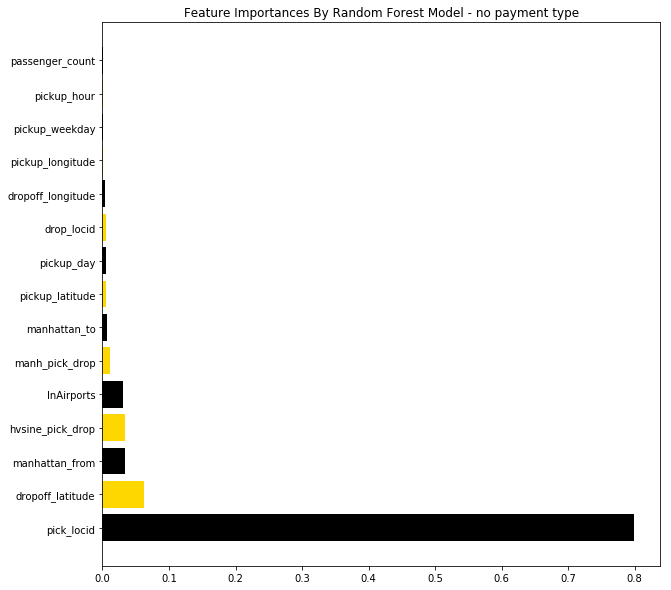

In [33]:
predictors = train.columns.values
importances=forest.feature_importances_
std = np.std([forest.feature_importances_ for tree in forest.estimators_],axis=0)
print(std)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances By Random Forest Model - no payment type")
plt.barh(range(len(indices)), importances[indices],
       color=["black","gold"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');

Text(0.5,1,'Learning Curve for 18x1 Model')

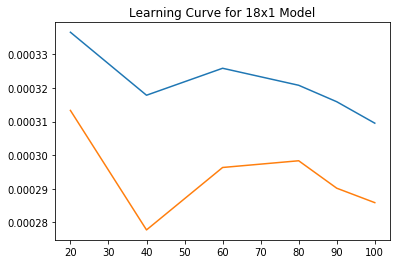

In [122]:
#Learning curve for Keras model for Fare prediction
#From the graph model needs more training
percents = [20, 40, 60, 80, 90, 100]
test_mse = [0.00033660618510281885,
            0.00031786012743418635,
            0.00032588690468469766,
            
            0.00032082232622434594,
            0.00031592803954051066,
            0.0003095449725446473
           ]
train_mse= [0.00031334009201490525,
           0.0002777785048886469,
           0.0002963579107385092,
            
           0.0002983579696845688,
           0.000290192603117889,
           0.0002858966877864832]
plt.plot(percents,test_mse)
plt.plot(percents, train_mse)
plt.title("Learning Curve for 18x1 Model")